In [1]:
import torch
import numpy as np
import pandas as pd
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

from data import Dataset

In [2]:

general_name = 'data_mnist_K_1_N_1_fixtransition_False_amortize_False_learnreverse_True_vanillaepoches_0'

NUM_EVALS = 3

In [3]:
args = get_args()

args.device = "cuda:1"
args.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=args.torchType, device=args.device),
                                            scale=torch.tensor(1., dtype=args.torchType, device=args.device))
dataset = Dataset(args, args.device)

In [4]:
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        args[key] = int(value)
    elif value in ['True', 'False']:
        args[key] = True if value=='True' else False
    else:
        args[key] = value

In [5]:
#### First, we load train models and fix their params
decoder = torch.load('./models/mnist/best_decoder_{}.pt'.format(general_name), map_location=args.device)
decoder.eval()
for p in decoder.parameters():
    p.requires_grad_(False)
target = NN_bernoulli(args, decoder, args.device)

In [ ]:
encoder = torch.load('./models/mnist/best_encoder_{}.pt'.format(general_name), map_location=args.device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad_(False)

In [ ]:
transitions = torch.load('./models/mnist/best_transitions_{}.pt'.format(general_name), map_location=args.device)
transitions.eval()
if args.amortize:
    transitions.device = args.device
else:
    for k in range(args.K):
        transitions[k].device = args.device
for p in transitions.parameters():
    p.requires_grad_(False)

In [ ]:
if args.learnable_reverse:
    reverse_kernel = torch.load('./models/mnist/best_reverse_{}.pt'.format(general_name), map_location=args.device)
    reverse_kernel.eval()
    reverse_kernel.device = args.device
    for p in reverse_kernel.parameters():
        p.requires_grad_(False)

Saved samples to ./pics/mnist_epoch_-1_K_1_N_1_amortize_False.png


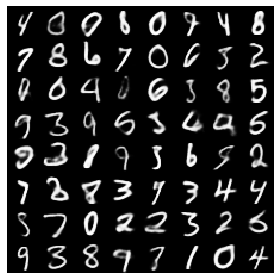

In [6]:
plot_digit_samples(samples=get_samples(target.decoder,
                                       torch.distributions.Normal(loc=torch.tensor(0., device=args.device),
                                                                 scale=torch.tensor(1., device=args.device)).sample((64, args.z_dim))),
                   args=args, epoch=-1)

### NLL estimation using importance sampling with inference part from training

In [7]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [8]:
# def compute_marginal_q(z_final, K, x, mu=None, sigma=None):
#     aux_matrix = torch.empty((z_final.shape[0], 3**K), device=device, dtype=torchType)
#     directions_all = np.array(list(itertools.product(np.arange(3) - 1, repeat=K)))
#     cond_distr = torch.distributions.Normal(loc=mu, scale=sigma)
#     for d_num, directions in enumerate(directions_all):
#         sum_log_alpha = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for grad log alpha accumulation
#         sum_log_jacobian = torch.zeros(z_final.shape[0], dtype=torchType, device=device) # for log_jacobian accumulation
#         z = z_final
#         for k in range(K)[::-1]:
#             if directions[k]==1.:
#                 current_log_alphas = transitions[k].get_log_alpha_1(z_old=z, x=x)
#             elif directions[k]==-1:
#                 current_log_alphas = transitions[k].get_log_alpha_m1(z_old=z, x=x)
#             else:
#                 current_log_alphas = transitions[k].get_log_alpha_0(z_old=z, x=x)
#             z_upd, log_jac = transitions[k].make_transition(z_old=z, x=x, directions=directions[k] * torch.ones(z.shape[0], dtype=torchType, device=device),
#                                                             k=cond_vectors[k]) # sample new positions and log_jacobians of transformations
#             sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
#             sum_log_alpha = sum_log_alpha + current_log_alphas
#             z = z_upd
#         log_q_joint = cond_distr.log_prob(z).sum(1) + sum_log_jacobian + sum_log_alpha
#         aux_matrix[:, d_num] = log_q_joint
#     loq_q_marginal = torch.logsumexp(aux_matrix, dim=1)
#     return loq_q_marginal

In [9]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = encoder(test_batch)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None

        for k in range(args.K):
    #         pdb.set_trace()
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=test_batch,
                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        nll_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=test_batch, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)

        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [1:15:26<00:00,  4.53s/it]


In [10]:
print(means)

[-91.25834, -91.260216, -91.23415]


In [11]:
print('Mean', np.mean(means))
print('Std', np.std(means))

Mean -91.25091
Std 0.011868138


In [8]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_same_inference_part']

In [9]:
d

{'data': ['mnist'],
 'K': [5],
 'N': [1],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'hoffmanlike': [True],
 'separateparams': [True],
 'usebatchnorm': [True],
 'decoder': ['deconv'],
 'eval_method': ['IS_with_same_inference_part']}

In [15]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


### NLL estimation using IS and separately trained encoder

In [7]:
from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive
import torch.nn as nn

In [8]:
encoder_aux = Inf_network(args).to(args.device)
best_encoder_aux = Inf_network(args).to(args.device)
n_flows = 3

flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    flows.append(one_flows)
variational_flow = nn.ModuleList(flows)

best_flows = []
for i in range(n_flows):
    one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim], param_dims=[2 * args.z_dim] * 3).to(args.device)
    one_flows = NeuralAutoregressive(one_arn, hidden_units=64)
    best_flows.append(one_flows)
best_variational_flow = nn.ModuleList(best_flows)

params = list(encoder_aux.parameters()) + list(variational_flow.parameters())

optimizer_aux = torch.optim.Adam(params=params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


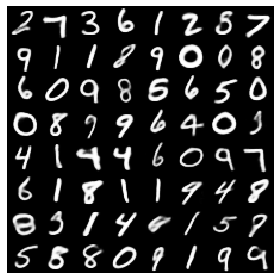

  0%|          | 1/1000 [00:11<3:15:21, 11.73s/it]

Current validation ELBO (epoch 0): -108.5027
Best validation ELBO  -108.5027


  1%|          | 10/1000 [01:57<3:13:43, 11.74s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


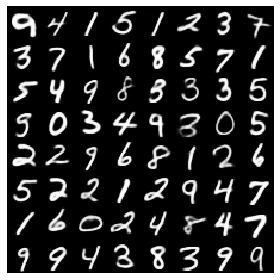

  1%|          | 11/1000 [02:08<3:14:03, 11.77s/it]

Current validation ELBO (epoch 10): -93.682884
Best validation ELBO  -93.49974


  2%|▏         | 20/1000 [03:54<3:12:26, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


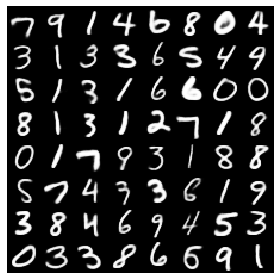

  2%|▏         | 21/1000 [04:06<3:12:30, 11.80s/it]

Current validation ELBO (epoch 20): -92.49543
Best validation ELBO  -92.49543


  3%|▎         | 30/1000 [05:52<3:10:28, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


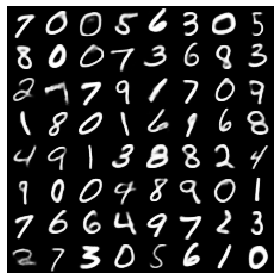

  3%|▎         | 31/1000 [06:04<3:10:34, 11.80s/it]

Current validation ELBO (epoch 30): -91.98691
Best validation ELBO  -91.83219


  4%|▍         | 40/1000 [07:50<3:08:31, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


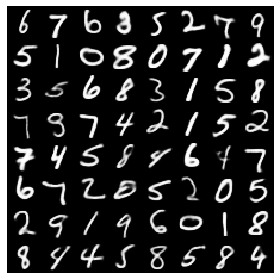

  4%|▍         | 41/1000 [08:02<3:08:37, 11.80s/it]

Current validation ELBO (epoch 40): -91.52314
Best validation ELBO  -91.52314


  5%|▌         | 50/1000 [09:48<3:06:30, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


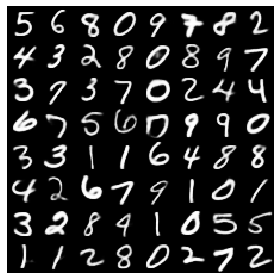

  5%|▌         | 51/1000 [10:00<3:06:34, 11.80s/it]

Current validation ELBO (epoch 50): -91.73025
Best validation ELBO  -91.38726


  6%|▌         | 60/1000 [11:46<3:04:34, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


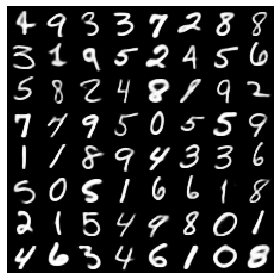

  6%|▌         | 61/1000 [11:58<3:04:36, 11.80s/it]

Current validation ELBO (epoch 60): -91.3885
Best validation ELBO  -91.2943


  7%|▋         | 70/1000 [13:44<3:02:42, 11.79s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


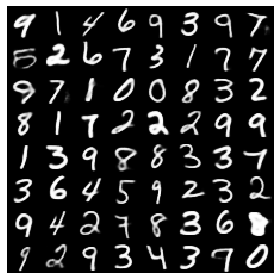

  7%|▋         | 71/1000 [13:56<3:02:55, 11.81s/it]

Current validation ELBO (epoch 70): -91.22786
Best validation ELBO  -91.12901


  8%|▊         | 80/1000 [15:42<3:00:39, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


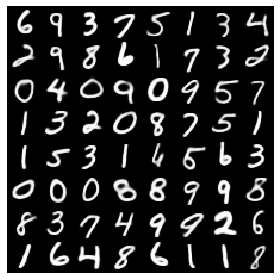

  8%|▊         | 81/1000 [15:54<3:00:42, 11.80s/it]

Current validation ELBO (epoch 80): -91.26399
Best validation ELBO  -90.98385


  9%|▉         | 90/1000 [17:40<2:58:37, 11.78s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


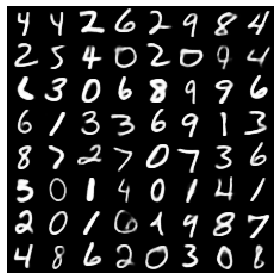

  9%|▉         | 91/1000 [17:51<2:58:40, 11.79s/it]

Current validation ELBO (epoch 90): -91.10817
Best validation ELBO  -90.98385


 10%|█         | 100/1000 [19:38<2:56:57, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


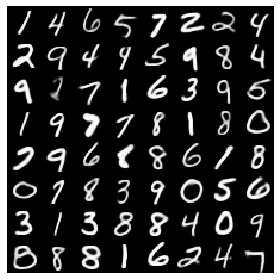

 10%|█         | 101/1000 [19:49<2:57:04, 11.82s/it]

Current validation ELBO (epoch 100): -91.041214
Best validation ELBO  -90.938286


 11%|█         | 110/1000 [21:36<2:55:11, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


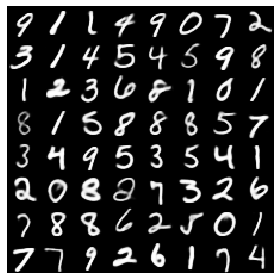

 11%|█         | 111/1000 [21:48<2:55:16, 11.83s/it]

Current validation ELBO (epoch 110): -90.96956
Best validation ELBO  -90.88115


 12%|█▏        | 120/1000 [23:34<2:53:13, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


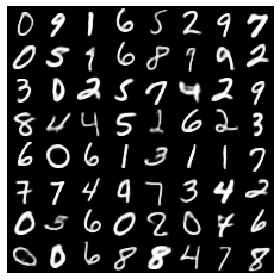

 12%|█▏        | 121/1000 [23:46<2:53:16, 11.83s/it]

Current validation ELBO (epoch 120): -91.14881
Best validation ELBO  -90.88115


 13%|█▎        | 130/1000 [25:32<2:51:18, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


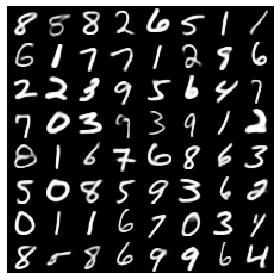

 13%|█▎        | 131/1000 [25:44<2:51:20, 11.83s/it]

Current validation ELBO (epoch 130): -90.7361
Best validation ELBO  -90.7361


 14%|█▍        | 140/1000 [27:30<2:49:18, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


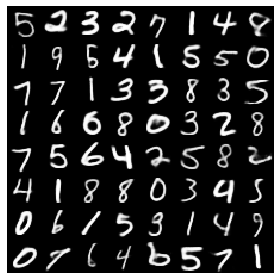

 14%|█▍        | 141/1000 [27:42<2:49:24, 11.83s/it]

Current validation ELBO (epoch 140): -91.148346
Best validation ELBO  -90.7361


 15%|█▌        | 150/1000 [29:29<2:47:19, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


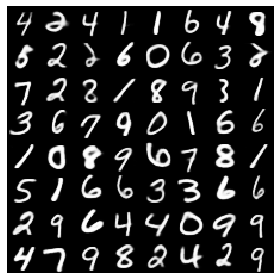

 15%|█▌        | 151/1000 [29:40<2:47:20, 11.83s/it]

Current validation ELBO (epoch 150): -90.89378
Best validation ELBO  -90.7361


 16%|█▌        | 160/1000 [31:27<2:45:23, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


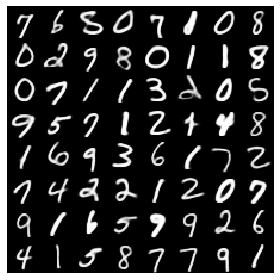

 16%|█▌        | 161/1000 [31:39<2:45:25, 11.83s/it]

Current validation ELBO (epoch 160): -90.999855
Best validation ELBO  -90.701904


 17%|█▋        | 170/1000 [33:25<2:43:17, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


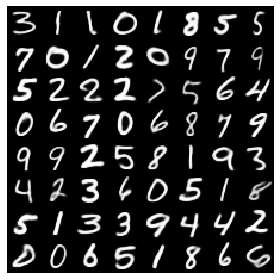

 17%|█▋        | 171/1000 [33:37<2:43:21, 11.82s/it]

Current validation ELBO (epoch 170): -90.820656
Best validation ELBO  -90.701904


 18%|█▊        | 180/1000 [35:23<2:41:31, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


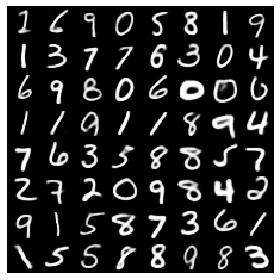

 18%|█▊        | 181/1000 [35:35<2:41:38, 11.84s/it]

Current validation ELBO (epoch 180): -91.181076
Best validation ELBO  -90.701904


 19%|█▉        | 190/1000 [37:21<2:39:32, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


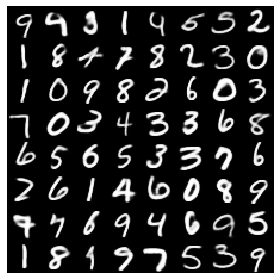

 19%|█▉        | 191/1000 [37:33<2:39:34, 11.83s/it]

Current validation ELBO (epoch 190): -90.85585
Best validation ELBO  -90.701904


 20%|██        | 200/1000 [39:19<2:37:31, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


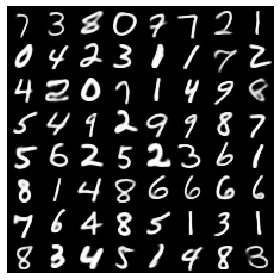

 20%|██        | 201/1000 [39:31<2:37:32, 11.83s/it]

Current validation ELBO (epoch 200): -90.75434
Best validation ELBO  -90.66368


 21%|██        | 210/1000 [41:18<2:35:38, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


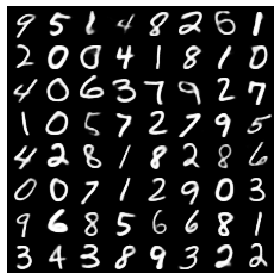

 21%|██        | 211/1000 [41:30<2:35:40, 11.84s/it]

Current validation ELBO (epoch 210): -90.735245
Best validation ELBO  -90.64058


 22%|██▏       | 220/1000 [43:16<2:33:29, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


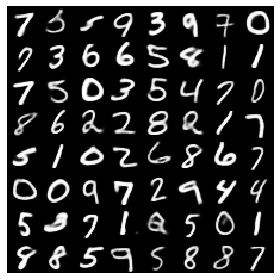

 22%|██▏       | 221/1000 [43:28<2:33:36, 11.83s/it]

Current validation ELBO (epoch 220): -90.81557
Best validation ELBO  -90.64058


 23%|██▎       | 230/1000 [45:14<2:31:34, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


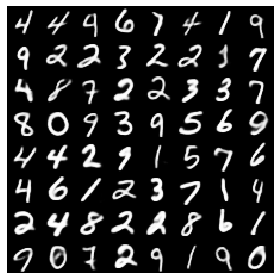

 23%|██▎       | 231/1000 [45:26<2:31:50, 11.85s/it]

Current validation ELBO (epoch 230): -90.71485
Best validation ELBO  -90.627266


 24%|██▍       | 240/1000 [47:12<2:29:37, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


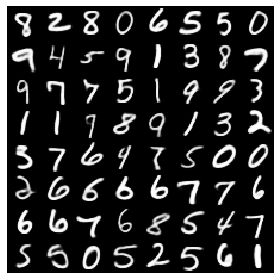

 24%|██▍       | 241/1000 [47:24<2:29:38, 11.83s/it]

Current validation ELBO (epoch 240): -90.71202
Best validation ELBO  -90.625305


 25%|██▌       | 250/1000 [49:10<2:27:40, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


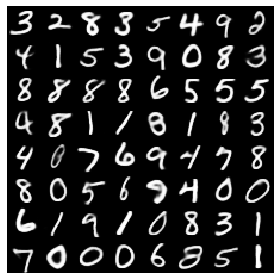

 25%|██▌       | 251/1000 [49:22<2:27:41, 11.83s/it]

Current validation ELBO (epoch 250): -90.82211
Best validation ELBO  -90.57322


 26%|██▌       | 260/1000 [51:09<2:25:45, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


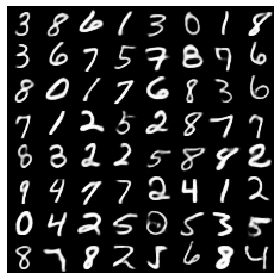

 26%|██▌       | 261/1000 [51:21<2:25:46, 11.84s/it]

Current validation ELBO (epoch 260): -90.70199
Best validation ELBO  -90.57322


 27%|██▋       | 270/1000 [53:07<2:23:43, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


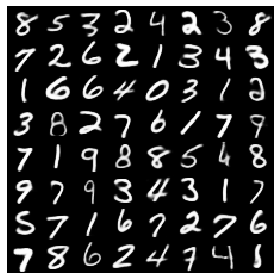

 27%|██▋       | 271/1000 [53:19<2:23:43, 11.83s/it]

Current validation ELBO (epoch 270): -90.5443
Best validation ELBO  -90.5443


 28%|██▊       | 280/1000 [55:05<2:21:49, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


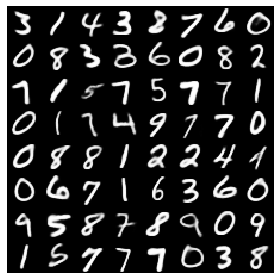

 28%|██▊       | 281/1000 [55:17<2:21:51, 11.84s/it]

Current validation ELBO (epoch 280): -90.80275
Best validation ELBO  -90.5443


 29%|██▉       | 290/1000 [57:03<2:19:39, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


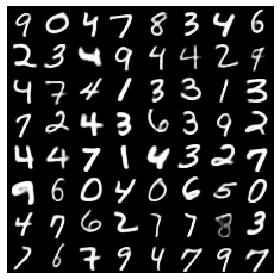

 29%|██▉       | 291/1000 [57:15<2:19:39, 11.82s/it]

Current validation ELBO (epoch 290): -90.77702
Best validation ELBO  -90.5443


 30%|███       | 300/1000 [59:01<2:17:42, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


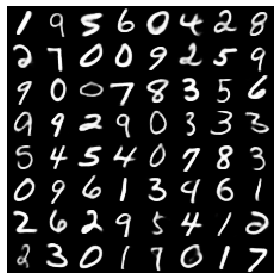

 30%|███       | 301/1000 [59:13<2:17:41, 11.82s/it]

Current validation ELBO (epoch 300): -90.54848
Best validation ELBO  -90.43331


 31%|███       | 310/1000 [1:00:59<2:15:45, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


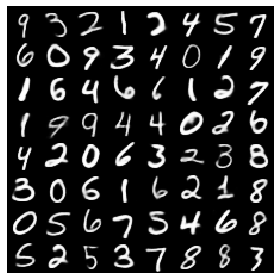

 31%|███       | 311/1000 [1:01:11<2:15:45, 11.82s/it]

Current validation ELBO (epoch 310): -90.65597
Best validation ELBO  -90.43331


 32%|███▏      | 320/1000 [1:02:58<2:13:54, 11.82s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


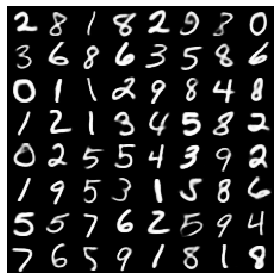

 32%|███▏      | 321/1000 [1:03:09<2:13:52, 11.83s/it]

Current validation ELBO (epoch 320): -90.80568
Best validation ELBO  -90.43331


 33%|███▎      | 330/1000 [1:04:56<2:11:54, 11.81s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


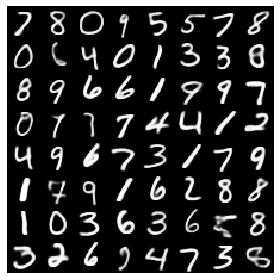

 33%|███▎      | 331/1000 [1:05:08<2:11:54, 11.83s/it]

Current validation ELBO (epoch 330): -90.91674
Best validation ELBO  -90.43331


 34%|███▍      | 340/1000 [1:06:54<2:09:50, 11.80s/it]

Saved samples to ./pics/mnist_epoch_-2_K_1_N_1_amortize_False.png


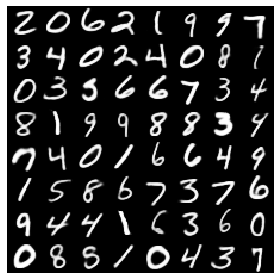

 34%|███▍      | 341/1000 [1:07:06<2:09:53, 11.83s/it]

Current validation ELBO (epoch 340): -90.57232
Best validation ELBO  -90.43331


 35%|███▍      | 347/1000 [1:08:28<2:08:52, 11.84s/it]

Early stopping on epoch 347 (effectively trained for 297 epoches)


In [10]:
##### First, we need to train it #####
best_elbo = -float('inf')
current_tolerance = 0

iterator = tqdm(range(1000))
for ep in iterator:
    for train_batch in dataset.next_train_batch():
        mu, sigma = encoder_aux(train_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=train_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q)
        (-elbo).backward()
        optimizer_aux.step()
        optimizer_aux.zero_grad()
    if ep % 10 == 0:
        plot_digit_samples(samples=get_samples(target.decoder,
                                       z_new[:64]),
                   args=args, epoch=-2)
    ##### Validation #####
    elbo_list = []
    for val_batch in dataset.next_val_batch():
        mu, sigma = encoder_aux(val_batch)
        u = args.std_normal.sample(mu.shape)
        z = mu + u * sigma
        z_prev = z
        sum_log_jac = 0.
        for flow in variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=val_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        elbo = torch.mean(log_p - log_q).cpu().detach().numpy()
        elbo_list.append(elbo)
    current_elbo_val = np.mean(elbo_list)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        best_encoder_aux.load_state_dict(encoder_aux.state_dict())
        best_variational_flow.load_state_dict(variational_flow.state_dict())
    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            iterator.close()
            break
    if ep % 10 == 0:
        print('Current validation ELBO (epoch {}):'.format(ep), current_elbo_val)
        print('Best validation ELBO ', best_elbo)

In [11]:
for p in best_encoder_aux.parameters():
    p.requires_grad_(False)
for p in best_variational_flow.parameters():
    p.requires_grad_(False)  

In [12]:
torch.save(best_encoder_aux, './eval_models/best_encoder_aux.pt')
torch.save(best_variational_flow, './eval_models/best_variational_flow.pt')

In [13]:
import gc
del encoder_aux
del variational_flow
del current_elbo_val
del params
del optimizer_aux
del elbo
del elbo_list
del z
del log_p
del log_q
del mu
del sigma
# del encoder
# del transitions
# del reverse_kernel
del sum_log_jac
gc.collect()
torch.cuda.empty_cache()

In [14]:
best_encoder_aux = torch.load('./eval_models/best_encoder_aux.pt')

In [15]:
best_variational_flow = torch.load('./eval_models/best_variational_flow.pt')

In [16]:
means = []
stds = []
for _ in range(NUM_EVALS):
    nll = []
    for test_batch in tqdm(dataset.next_test_batch(), total=dataset.test.shape[0] // dataset.test_batch_size):
        mu, sigma = best_encoder_aux(test_batch)
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u

        z_prev = z
        sum_log_jac = 0.
        for flow in best_variational_flow:
            z_new = flow(z_prev)
            sum_log_jac += flow.log_abs_det_jacobian(z_prev, z_new)
            z_prev = z_new
        log_p = target.get_logdensity(x=test_batch, z=z_new)
        log_q = args.std_normal.log_prob(u).sum(1) - torch.sum(torch.log(sigma), 1) - sum_log_jac
        nll_current = torch.mean(log_p - log_q)
        nll.append(nll_current.cpu().detach().numpy())
    means.append(np.mean(nll))

100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [17]:
d = {}
for key, value in zip(general_name.split('_')[::2], general_name.split('_')[1::2]):
    if value.isdigit():
        d[key] = [int(value)]
    elif value in ['True', 'False']:
        d[key] = [True if value=='True' else False]
    else:
        d[key] = [value]
d['Mean'] = [np.mean(means)]
d['std'] = [np.std(means)]
d['eval_method'] = ['IS_with_separately_trained_inference_part']

In [20]:
d

{'data': ['mnist'],
 'K': [1],
 'N': [1],
 'fixtransition': [False],
 'amortize': [False],
 'learnreverse': [True],
 'vanillaepoches': [0],
 'Mean': [-88.976555],
 'std': [0.029941047],
 'eval_method': ['IS_with_separately_trained_inference_part'],
 'use_batchnorm': [True],
 'decoder': ['deconv'],
 'hoffmanlike': [True],
 'separateparams': [True]}

In [21]:
df_cur = pd.DataFrame(data=d, columns=d.keys())
file_name = './nll_results.csv'
if os.path.exists(file_name):
    df = pd.read_csv(file_name)
    df_cur = pd.concat([df, df_cur])
df_cur.to_csv(file_name, index=False)

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [28]:
df.to_csv(file_name, index=False)